In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.models import Sequential, load_model
from keras.optimizers import adam
from sklearn.metrics import roc_auc_score 

Using TensorFlow backend.


In [4]:
CURRENT_SET = 0

In [5]:
df = pd.read_csv(f'data/working_train_df_{CURRENT_SET}.csv')
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_153705,0,12.3251,3.7835,11.6726,4.4771,11.1765,-5.6920,5.8932,12.4260,...,-2.2082,4.2236,4.3090,3.4810,14.9629,-0.7598,7.9183,8.9676,11.4002,-4.7609
1,train_178870,0,11.8970,5.0792,7.9301,6.4788,9.3639,4.2042,6.5899,16.3848,...,3.8722,11.2516,0.2554,6.9514,15.9305,-2.5133,-0.6977,9.6821,19.7626,10.4399
2,train_77100,0,8.1522,-6.1382,14.0154,11.3520,12.0944,-3.0461,4.0223,20.1020,...,-0.0441,8.9315,2.0132,4.9495,21.1372,1.0498,12.0516,8.4104,9.4328,14.7863
3,train_172656,1,13.2053,-2.9593,14.1576,7.0573,13.3132,-15.6966,4.0718,16.2601,...,10.1823,6.6488,3.2586,6.2694,17.6702,0.4203,11.0431,9.5062,17.0413,6.4602
4,train_130313,1,13.9468,4.3059,12.0891,7.8422,12.7303,-19.9832,6.2974,15.0854,...,3.1895,4.7566,2.3023,8.0319,18.6647,1.5099,2.3106,8.2752,14.2200,4.9702


In [6]:
df_valid = pd.read_csv(f'data/valid_splitted.csv')
df_valid.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
39308,train_39308,0,6.2235,-3.6087,11.7680,6.0052,11.5614,-7.4537,4.7117,20.0163,...,-0.0174,6.4734,2.3937,1.4221,20.6887,2.9036,10.3056,9.0615,18.2392,-2.6482
179236,train_179236,0,10.0275,-6.8930,10.1656,6.1174,9.5721,-7.2208,6.8899,12.1197,...,0.5192,6.7129,1.3789,0.1898,15.7231,0.9399,2.1101,10.5431,15.5558,4.3572
113362,train_113362,0,12.3167,-0.2938,9.0521,6.3380,13.6952,-4.3922,5.6375,16.5737,...,9.0286,1.6299,2.5299,8.5810,16.9100,0.5776,4.0023,9.9524,20.8813,-24.0936
94934,train_94934,0,8.5020,-4.5557,12.3567,6.0692,12.4196,-9.6285,4.5737,18.6622,...,-2.7295,3.6510,3.0502,3.5242,16.1205,-1.8683,8.2394,8.4591,18.9237,-24.0737
20509,train_20509,1,15.1258,-7.7021,16.3087,8.5685,11.8125,0.3309,4.9676,16.6815,...,-2.4755,15.7240,-1.2651,7.6492,21.7630,0.2565,6.9437,10.1212,16.8096,5.2019


In [7]:
X_train = df.drop(columns=['ID_code', 'target']).values
y_train = df['target'].values

X_valid = df_valid.drop(columns=['ID_code', 'target']).values
y_valid = df_valid['target'].values

In [8]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(34046, 200) (34046,)
(40000, 200) (40000,)


In [7]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        x1 = x[y==1].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[:,c][ids]
        xs.append(x1)

    for i in range(t//2):
        x1 = x[y==0].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[:,c][ids]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [8]:
# CPU times: user 13.3 s, sys: 8.3 s, total: 21.6 s
# Wall time: 18 s
# CPU times: user 3.1 s, sys: 405 ms, total: 3.51 s
# Wall time: 1.03 s
%time X_train_aug, y_train_aug = augment(X_train, y_train)

CPU times: user 1.1 s, sys: 108 ms, total: 1.21 s
Wall time: 231 ms


In [9]:
X_train_aug_sqr = X_train_aug
X_valid_sqr = X_valid

In [10]:
# X_train_aug_sqr = np.append(X_train_aug, X_train_aug**2, axis=1)
# X_train_aug_sqr = np.append(X_train_aug_sqr, X_train_aug**3, axis=1)
# X_valid_sqr = np.append(X_valid, X_valid**2, axis=1)
# X_valid_sqr = np.append(X_valid_sqr, X_valid**3, axis=1)

In [11]:
X_train_aug_sqr.shape, X_valid_sqr.shape

((80250, 200), (8018, 200))

In [12]:
y_train_aug_cat = np.array([y_train_aug, 1-y_train_aug]).T
y_valid_cat = np.array([y_valid, 1-y_valid]).T

# Model solo con train

In [13]:
from keras.regularizers import l1

In [14]:
#l1_reg = l1(l=0.0001)

In [15]:
model = Sequential()
p_do = 0.5
model.add(Dense(200, input_shape=(X_train_aug_sqr.shape[1],))) #kernel_regularizer=l1_reg,
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p_do))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p_do))

# model.add(Dense(200))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(p_do))

model.add(Dense(2, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
__________

In [16]:
# from clr import LRFinder

# model.compile('SGD', loss='categorical_crossentropy', metrics=['accuracy'])
# batch_size = 256
# lr_callback = LRFinder(len(X_train_aug), batch_size,
#                        1e-6, 1,
#                        # validation_data=(X_val, Y_val),
#                        lr_scale='exp', save_dir='data')

# # Ensure that number of epochs = 1 when calling fit()
# model.fit(X_train_aug, y_train_aug_cat, epochs=1, batch_size=batch_size, callbacks=[lr_callback])

In [17]:
# lr_callback.plot_schedule()

In [18]:
# from clr import OneCycleLR

# lr_manager = OneCycleLR(1e-2)
                        
# model.fit(X_train_aug, y_train_aug_cat, 
#           epochs=10, 
#           batch_size=batch_size, 
#           validation_data=(X_test, y_test_cat), 
#           callbacks=[lr_manager])

In [19]:
from keras.callbacks import ModelCheckpoint

In [20]:
checkpoint = ModelCheckpoint('best.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [21]:
batch_size = 256
optimizer = adam(lr=1e-4)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(X_train_aug_sqr, y_train_aug_cat, 
          batch_size=batch_size, 
          epochs=75, 
          validation_data=(X_valid_sqr, y_valid_cat), 
          callbacks = [checkpoint],
          verbose=1) 
          #class_weight=class_weight_keras)

Train on 80250 samples, validate on 8018 samples
Epoch 1/75
80250/80250 [==============================] - 2s 21us/step - loss: 0.8289 - acc: 0.5645 - val_loss: 0.6125 - val_acc: 0.6621

Epoch 00001: val_loss improved from inf to 0.61254, saving model to best.hdf5
Epoch 2/75
80250/80250 [==============================] - 1s 11us/step - loss: 0.7011 - acc: 0.6249 - val_loss: 0.5715 - val_acc: 0.7093

Epoch 00002: val_loss improved from 0.61254 to 0.57148, saving model to best.hdf5
Epoch 3/75
80250/80250 [==============================] - 1s 11us/step - loss: 0.6425 - acc: 0.6596 - val_loss: 0.5482 - val_acc: 0.7284

Epoch 00003: val_loss improved from 0.57148 to 0.54824, saving model to best.hdf5
Epoch 4/75
80250/80250 [==============================] - 1s 11us/step - loss: 0.6007 - acc: 0.6847 - val_loss: 0.5351 - val_acc: 0.7406

Epoch 00004: val_loss improved from 0.54824 to 0.53505, saving model to best.hdf5
Epoch 5/75
80250/80250 [==============================] - 1s 11us/step - lo

# Predictions

In [23]:
from matplotlib import pyplot as plt

In [24]:
model.save_weights('last_epoch.hdf5')

In [25]:
model.load_weights('last_epoch.hdf5')

In [26]:
import time

In [27]:
predictions_train = model.predict(X_train_aug_sqr, verbose=1)
roc_auc_score(y_train_aug_cat[:,0], predictions_train[:,0])

80250/80250 [==============================] - 1s 13us/step


0.8964086400565867

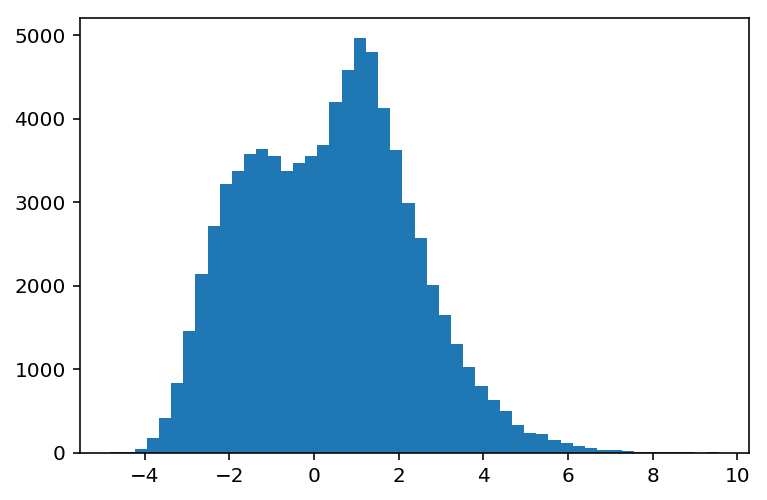

In [28]:
_ = plt.hist(np.log(predictions_train[:,0]/predictions_train[:,1]), 50)

# Validation

In [29]:
predictions = model.predict(X_valid_sqr, verbose=1)
roc_auc_score(y_valid_cat, predictions)

8018/8018 [==============================] - 0s 15us/step


0.8626164162462574

In [30]:
model.load_weights('best.hdf5')

In [31]:
model.save(f'trained_models/MLP_keras_balanced_{CURRENT_SET}.h5')

In [32]:
predictions = model.predict(X_valid_sqr, verbose=1)
roc_auc_score(y_valid_cat, predictions)

8018/8018 [==============================] - 0s 14us/step


0.8626164162462574

In [33]:
# 0 => 0.862447463854684
# 1 => 0.8639864740968912
# 2 => 0.8584454091674291
# 3 => 0.8583561184257356
# 4 => 0.8636952850996176
# 5 => 0.8657505423877632
# 6 => 0.8586787081274665
# 7 => 0.8650569108068622
# 8 => 0.8596024034021637